# Check resolution with orthogonal dataset

### Notebook configuration

In [1]:
run_number          = 4734
input_dst_filename  = f"$IC_DATA/Kr/dst_{run_number}_filtered.root.h5"

Zrange  =   50,  550
XYrange = -200,  200
Erange  =   30,   50
Znbins  =   10
XYnbins =   60
Enbins  =  200

split_fraction = 0.75

# Plotting style
default_cmap = "viridis"
figure_size  = 16, 12
font_size    = 15

global_linewidth    = 4
subfit_linewidth    = 4
global_linecolor    = "r"
subfit_linecolor    = "m g b y".split()
subfit_linecolor    = "b m slategrey c b y".split()


### Imports

In [2]:
import os
import time
import collections
import warnings

import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions  as dstf
import invisible_cities.reco.corrections    as corrf
import invisible_cities.io  .kdst_io        as kdstio

from invisible_cities.icaro. hst_functions import hist
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from invisible_cities.icaro. hst_functions import poisson_sigma
from invisible_cities.icaro. hst_functions import resolution
from invisible_cities.icaro. hst_functions import labels
from invisible_cities.icaro. hst_functions import resolution
from invisible_cities.icaro. hst_functions import measurement_string
from invisible_cities.icaro. hst_functions import gausstext

from icaro.core.fit_functions import fit_slices_2d_expo

%matplotlib inline

### Initialization

In [3]:
Zbins     = np.linspace(* Zrange,  Znbins+1)
Ebins     = np.linspace(* Erange,  Enbins+1)
XYbins    = np.linspace(*XYrange, XYnbins+1)
XYcenters = shift_to_bin_centers(XYbins)
XYpitch   = np.diff(XYbins)[0]

input_dst_filename   = os.path.expandvars(input_dst_filename)

plt.rcParams["figure.figsize"] = figure_size
plt.rcParams[  "font.size"   ] =   font_size

warnings.filterwarnings('ignore', category=tb.NaturalNameWarning)

### Read data

In [4]:
dst       = dstf.load_dst(input_dst_filename, "DST", "Events")
total_evt = len(dst)

train     = np.random.uniform(0, 1, size=total_evt) < split_fraction
train_dst = dst[ train]
test_dst  = dst[~train]

In [5]:
X  = train_dst.X   .values
Y  = train_dst.Y   .values
Z  = train_dst.Z   .values
T  = train_dst.time.values
T  = T - np.min(T)
E0 = train_dst.S2e .values

### Compute lifetime map

In [6]:
LT = fit_slices_2d_expo(X, Y, Z, E0, XYbins, XYbins, Znbins, zrange=Zrange, min_entries=1e2)[1]
ok = LT.value < -100

LT_mean  = np.nanmean(LT.value      [ok])
LTu_mean = np.nanmean(LT.uncertainty[ok])

LT , LTu      = np.where(ok, -LT.value, -LT_mean), np.where(ok,  LT.uncertainty, -LTu_mean)
LT_correction = corrf.LifetimeXYCorrection(LT, LTu, XYcenters, XYcenters)
Ez            = E0 * LT_correction(Z, X, Y).value

### Compute geometry map

In [7]:
*_, Eave, Eaveu = fitf.profileXY(X, Y, Ez, XYnbins, XYnbins, XYrange, XYrange)
ok              = Eave > 1e3

E_mean  = np.mean(Eave [ok])
Eu_mean = np.mean(Eaveu[ok])


Eave, Eaveu    = np.where(ok, Eave, E_mean), np.where(ok, Eaveu, Eu_mean)
GEO_correction = corrf.Correction((XYcenters, XYcenters), Eave, Eaveu, norm_strategy = "index", norm_opts = {"index": (30, 30)})
Exyz           = Ez * GEO_correction(X, Y).value

### Compute time correction

In [8]:
t, e, eu     = fitf.profileX(T, Ez, 100)
T_correction = corrf.Correction((t,), e, eu, norm_strategy = "max")
Exyzt        = Exyz * T_correction(T).value

In [9]:
xy_data       = collections.namedtuple(      "xy_data", "x y xu yu"       )
reso_fit_data = collections.namedtuple("reso_fit_data", "xy residuals f R")

def measure_resolution(E, bkg=fitf.gauss):
    y, x  = np.histogram(E, Ebins)
    x     = shift_to_bin_centers(x)
    xu    = np.diff(x)[0] * 0.5
    yu    = poisson_sigma(y)

    fun   = lambda x, *args: fitf.gauss(x, *args[:3]) + bkg(x, *args[3:])
    Npeak = np.size(E) * np.diff(Ebins)[0]
    Epeak = np.average( x            , weights=y)
    Speak = np.average((x - Epeak)**2, weights=y)**0.5

    bkg_seed = (Npeak*2, Epeak, Speak*50) if bkg is fitf.gauss else (1, 1, 1)
    sig_seed  = Npeak, Epeak, Speak

    seed = (*sig_seed, *bkg_seed)
    fit_range = (Epeak - 3 * Speak,
                 Epeak + 3 * Speak)
    f    = fitf.fit(fun, x, y, seed,
                    fit_range = fit_range,
                    sigma     = yu,
                    maxfev    = 10000)

    assert not np.any(np.isclose(f.values, seed)), f.values

    R   = resolution(f.values, f.errors, 41.5)
    sel = coref.in_range(x, *fit_range)
    ry  = (f.fn(x) - y) / yu
    return reso_fit_data(xy_data(x, y, xu, yu),
                         xy_data(x[sel], ry[sel], xu, yu[sel]),
                         f, R)

def plot(data, signal=fitf.gauss, bkg=fitf.gauss):
    print("Resolution at 41.5 keV:", measurement_string(*data.R[0]))
    print("Resolution at 2458 keV:", measurement_string(*data.R[1]))
    print("Chi2                  :", data.f.chi2)

    x = data.xy.x
    plt.errorbar    (x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
    plt.plot        (x, data.f.fn   (x)               , lw=global_linewidth, color=global_linecolor   )
    plt.plot        (x, signal(x, *data.f.values[ :3]), lw=subfit_linewidth, color=subfit_linecolor[0])
    plt.fill_between(x, signal(x, *data.f.values[ :3]),    0,     alpha=0.3, color=subfit_linecolor[0])
    plt.plot        (x, bkg   (x, *data.f.values[3: ]), lw=subfit_linewidth, color=subfit_linecolor[1])
    plt.fill_between(x, bkg   (x, *data.f.values[3: ]),    0,     alpha=0.3, color=subfit_linecolor[1])
    plt.text(plt.xlim()[0] + np.diff(plt.xlim()) * 0.05,
             max(data.xy.y) / 1.5,
             gausstext(data.f.values, data.f.errors, 41.5))
    plt.ylim(0)
    labels("E (keV)", "Entries")

### Corrections on the train data set

Resolution at 41.5 keV: 4.7244 +- 0.0083
Resolution at 2458 keV: 0.6139 +- 0.0011
Chi2                  : 5.89344689792


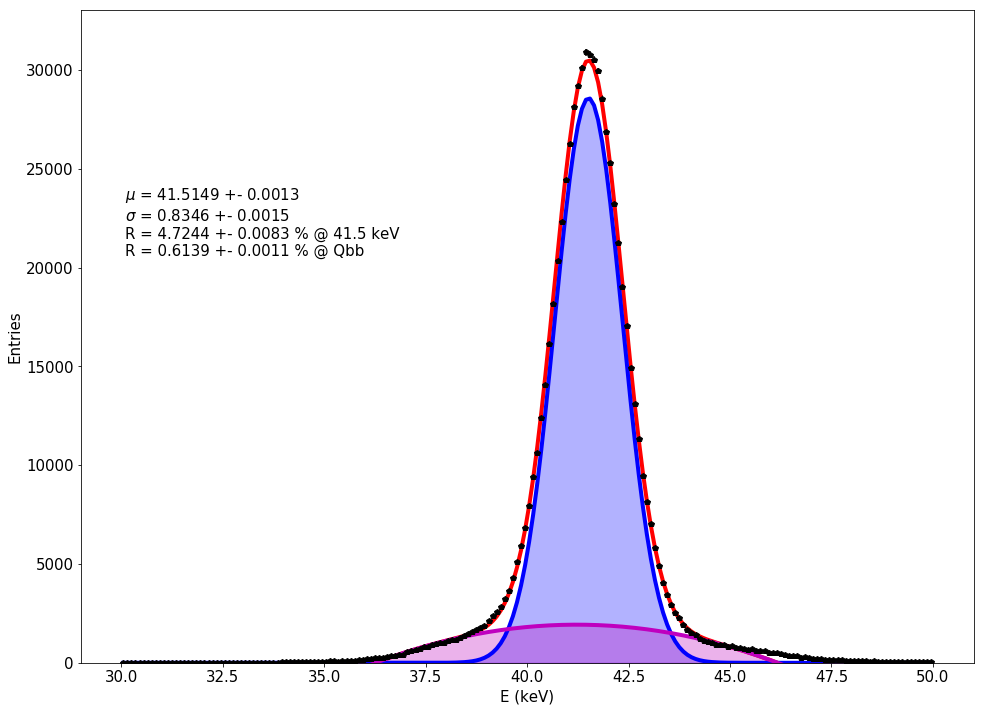

In [10]:
e    = Exyzt * 41.5/np.mean(Exyzt)
bkg  = fitf.polynom
data = measure_resolution(e, bkg=bkg)

plot(data, bkg=bkg)

Resolution at 41.5 keV: 4.753 +- 0.014
Resolution at 2458 keV: 0.6176 +- 0.0019
Chi2                  : 2.93748594552


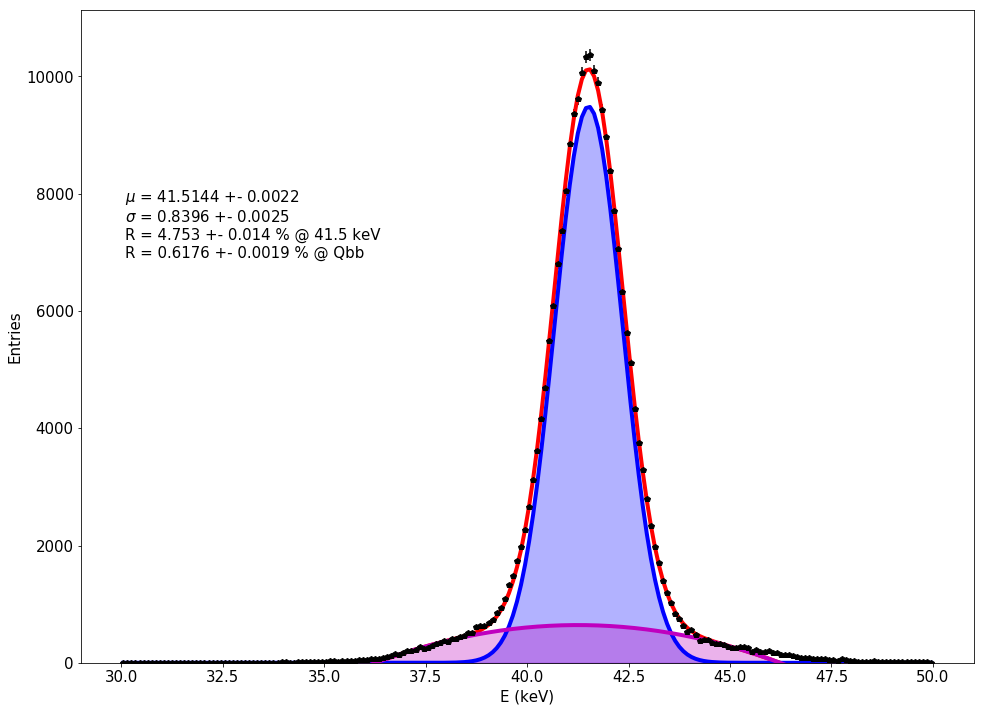

In [11]:
e    = test_dst.S2e.values
e    = e *  LT_correction(test_dst.Z.values,
                          test_dst.X.values,
                          test_dst.Y.values).value
e    = e * GEO_correction(test_dst.X.values,
                          test_dst.Y.values).value
e    = e *   T_correction(test_dst.time.values - 
                          test_dst.time.values.min()).value
e    = e * 41.5/np.mean(e)

bkg  = fitf.polynom
data = measure_resolution(e, bkg=bkg)

plot(data, bkg=bkg)